In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

1. Dataset

In [179]:
data = pd.read_csv('datasets/emotion_sentimen_dataset.csv', usecols=['text', 'Emotion'])
data.head(5)

,text,Emotion
0,Life is an incredible journey full of adventures!,happy
1,Every obstacle just fuels my anger more.,angry
2,"Sometimes, the silence of the room feels overw...",sad
3,I just don't feel strongly about anything today.,neutral
4,The sun shining through the leaves fills me wi...,happy


In [180]:
data.shape

(1146, 2)

In [181]:
data = data.dropna(subset=['text', "Emotion"])
data.head()

,text,Emotion
0,Life is an incredible journey full of adventures!,happy
1,Every obstacle just fuels my anger more.,angry
2,"Sometimes, the silence of the room feels overw...",sad
3,I just don't feel strongly about anything today.,neutral
4,The sun shining through the leaves fills me wi...,happy


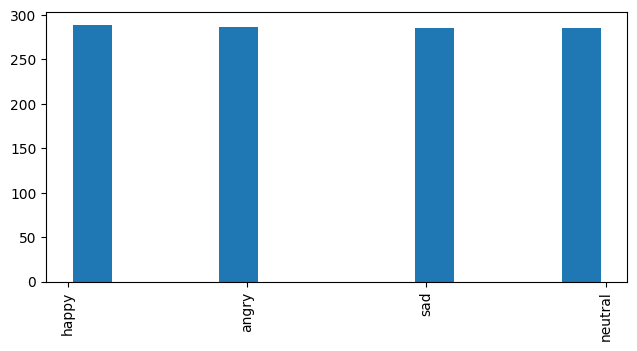

In [182]:
plt.figure(figsize=(7.5,3.5))  # Increase the figure size
plt.hist(data.Emotion, bins=11, rwidth=0.8)
plt.xticks(rotation=90) 
plt.show()

In [183]:

train_temp, test = train_test_split(data, test_size=0.2, stratify=data['Emotion'])
train, val = train_test_split(train_temp, test_size=0.25, stratify=train_temp['Emotion'])  # 0.25 x 0.8 = 0.2

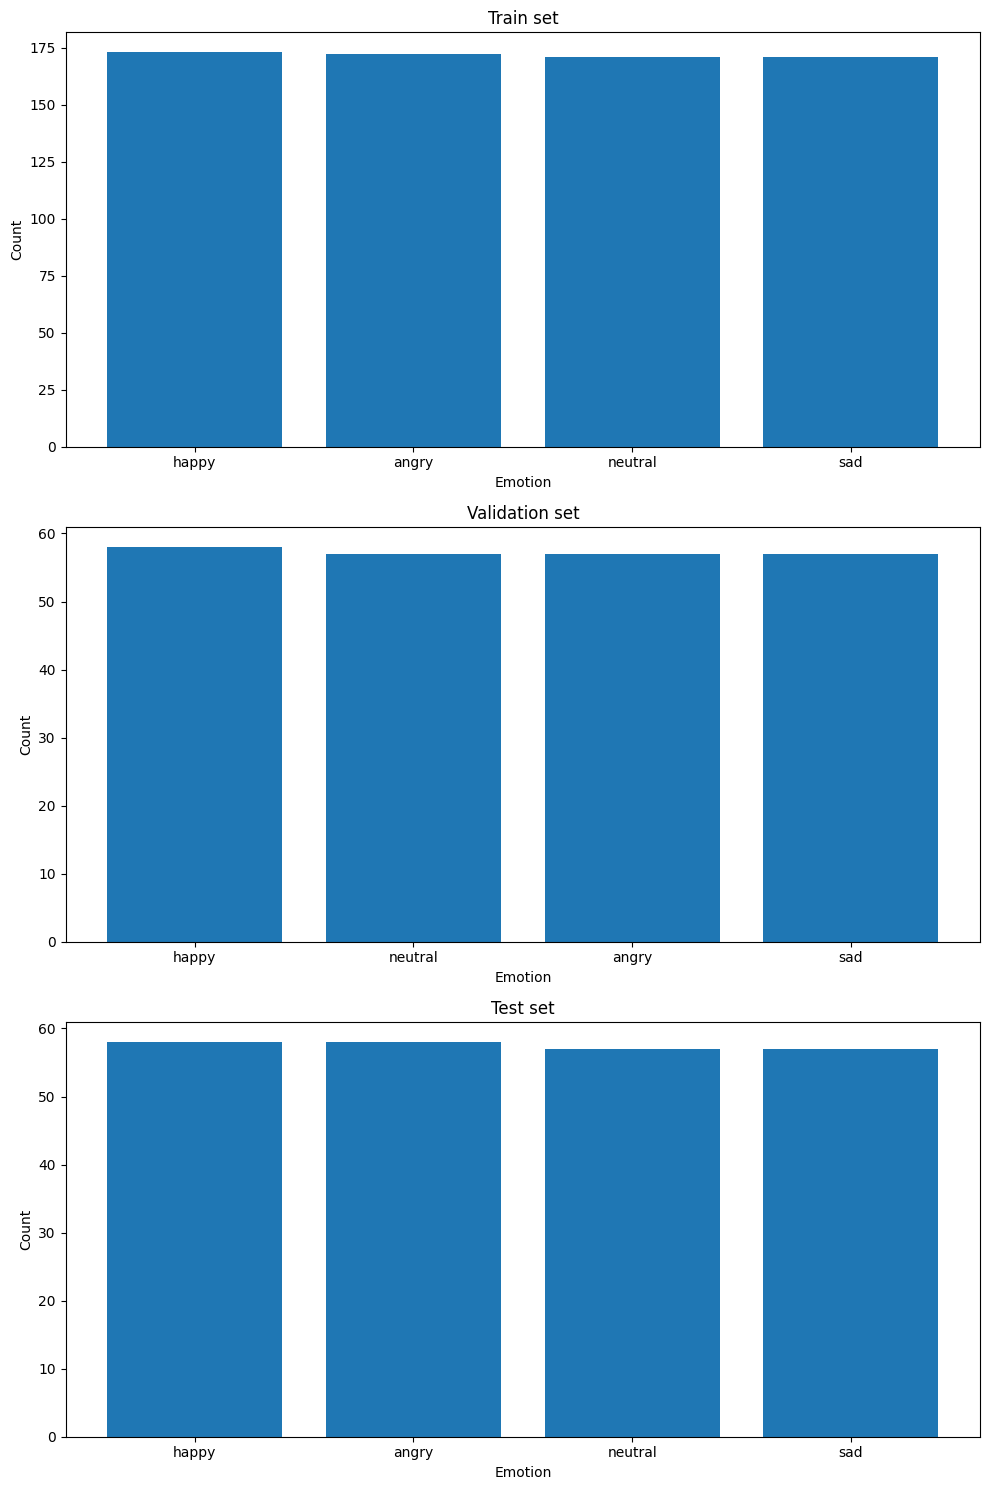

In [184]:

fig, axs = plt.subplots(3, figsize=(10, 15))

axs[0].bar(train['Emotion'].value_counts().index, train['Emotion'].value_counts().values)
axs[0].set_title('Train set')

axs[1].bar(val['Emotion'].value_counts().index, val['Emotion'].value_counts().values)
axs[1].set_title('Validation set')

axs[2].bar(test['Emotion'].value_counts().index, test['Emotion'].value_counts().values)
axs[2].set_title('Test set')

for ax in axs:
    ax.set_xlabel('Emotion')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [185]:
def df_to_dataset(dataframe, num_classes, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('Emotion')
    
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    
    num_classes = len(np.unique(labels))
    
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes) 
    df = df['text']
    ds = tf.data.Dataset.from_tensor_slices((df.values, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    
    return ds

In [186]:
train_data = df_to_dataset(train, num_classes=4)
val_data = df_to_dataset(val, num_classes=4)
test_data = df_to_dataset(test, num_classes=4) 

In [187]:
labels = train['Emotion'].unique()
print(labels)
num_classes = len(labels)


['angry' 'neutral' 'happy' 'sad']


2. Model

In [188]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20],
                        input_shape=[], dtype=tf.string, trainable=True)

num_classes = len(np.unique(labels))

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

model.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # Use CategoricalCrossentropy for multi-class classification
            metrics=['accuracy'])

In [189]:
model.evaluate(train_data)

22/22 [==============================] - 0s 3ms/step - loss: 1.3418 - accuracy: 0.4178


[1.3417575359344482, 0.41775837540626526]

In [190]:
model.evaluate(val_data)

8/8 [==============================] - 0s 2ms/step - loss: 1.3409 - accuracy: 0.4192


[1.3409405946731567, 0.4192139804363251]

In [191]:
history = model.fit(train_data, epochs=5, validation_data=val_data)


Epoch 1/5


22/22 [==============================] - 1s 16ms/step - loss: 1.2512 - accuracy: 0.4731 - val_loss: 1.1602 - val_accuracy: 0.6507
Epoch 2/5
22/22 [==============================] - 0s 13ms/step - loss: 1.0732 - accuracy: 0.7438 - val_loss: 1.0025 - val_accuracy: 0.7467
Epoch 3/5
22/22 [==============================] - 0s 15ms/step - loss: 0.9064 - accuracy: 0.7758 - val_loss: 0.8419 - val_accuracy: 0.7642
Epoch 4/5
22/22 [==============================] - 0s 16ms/step - loss: 0.7408 - accuracy: 0.8064 - val_loss: 0.6969 - val_accuracy: 0.8603
Epoch 5/5
22/22 [==============================] - 0s 15ms/step - loss: 0.5929 - accuracy: 0.8996 - val_loss: 0.5699 - val_accuracy: 0.8646


In [192]:
model.evaluate(test_data)

8/8 [==============================] - 0s 4ms/step - loss: 0.5637 - accuracy: 0.8478


[0.5636695027351379, 0.8478260636329651]

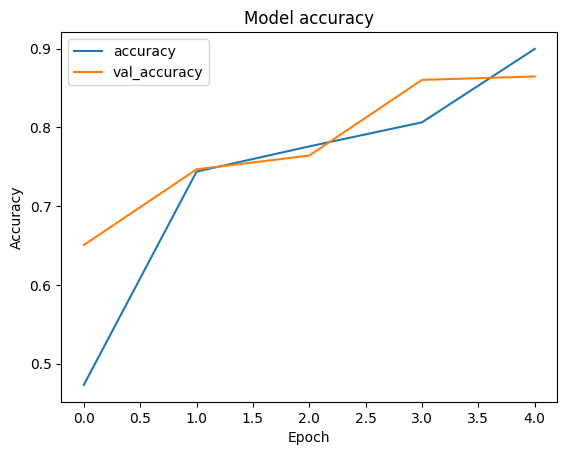

In [193]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [195]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])


model.evaluate(train_data)


model.evaluate(val_data)


history = model.fit(train_data, epochs=5, validation_data=val_data)


model.evaluate(test_data)


model.save('Models/emotions3.keras')

8/8 [==============================] - 0s 4ms/step - loss: 1.3851 - accuracy: 0.2838
Epoch 1/5
22/22 [==============================] - 5s 10ms/step - loss: 1.3600 - accuracy: 0.3333 - val_loss: 1.3121 - val_accuracy: 0.5502
Epoch 2/5
22/22 [==============================] - 0s 10ms/step - loss: 1.1714 - accuracy: 0.7001 - val_loss: 0.9543 - val_accuracy: 0.8384
Epoch 3/5
22/22 [==============================] - 0s 10ms/step - loss: 0.7625 - accuracy: 0.8574 - val_loss: 0.6369 - val_accuracy: 0.8908
Epoch 4/5
22/22 [==============================] - 0s 10ms/step - loss: 0.4581 - accuracy: 0.9549 - val_loss: 0.3444 - val_accuracy: 0.9258
Epoch 5/5
8/8 [==============================] - 0s 4ms/step - loss: 0.1184 - accuracy: 0.9652


3. Testing

In [196]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [197]:
model = tf.keras.models.load_model('Models/emotions3.keras')

In [198]:
import string

def preprocess_text(text):
    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

In [200]:
def predict_label(text):
    text = preprocess_text(text)

    text = tf.constant([text])  

    prediction = model.predict(text) 

    predicted_index = np.argmax(prediction[0])

    return predicted_index

text = "i am so happy for you"
print(labels[predict_label(text)])

1/1 [==============================] - 0s 34ms/step
happy
